In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from torch.utils.data import Dataset, DataLoader
import statistics
import seaborn as sns
import tensorflow as tf
import pickle

/Users/elvisyan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
'''datapath = "CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz"
data = np.load(datapath)
print(data, data['data'].shape, data['variable'])
with open('data.pkl', 'wb') as file:
    pickle.dump(data['data'], file)
all_data = data['data']'''#uncommen to read from npz  

'datapath = "CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz"\ndata = np.load(datapath)\nprint(data, data[\'data\'].shape, data[\'variable\'])\nwith open(\'data.pkl\', \'wb\') as file:\n    pickle.dump(data[\'data\'], file)\nall_data = data[\'data\']'

In [3]:
#uncomment if load pkl file
with open('data.pkl', 'rb') as file:
    all_data = pickle.load(file)

In [4]:
#data-preprocess util funcitons 
def convert_to_df(data):
    #data -> array of dimension [timesteps, funds, variables]
    #output is a dataframe with columns ['Timestep', 'FundID'] + var_names
    var_names = ['FC2Y', 'Beta', 'OA', 'CF', 'Variance', 'BEME', 'CTO', 'RNA', 'NI',
        'r12_2', 'CF2P', 'r36_13', 'ROA', 'r2_1', 'Resid_Var', 'DPI2A',
        'IdioVol', 'AC', 'PM', 'ATO', 'D2A', 'SUV', 'SGA2S', 'r12_7',
        'PCM', 'LT_Rev', 'D2P', 'Rel2High', 'LTurnover', 'ROE', 'MktBeta',
        'Investment', 'Lev', 'LME', 'E2P', 'ST_Rev', 'Spread', 'Q', 'A2ME',
        'NOA', 'C', 'OP', 'S2P', 'OL', 'AT', 'PROF', 'ages', 'flow',
        'exp_ratio', 'tna', 'turnover', 'Family_TNA', 'fund_no',
        'Family_r12_2', 'Family_flow', 'Family_age', 'F_ST_Rev', 'F_r2_1',
        'F_r12_2', 'sentiment']
    timesteps, funds, variables = data.shape
    timestep_column = np.repeat(np.arange(timesteps), funds)
    fundid_column = np.tile(np.arange(funds), timesteps)
    reshaped_data = data.reshape(timesteps * funds, variables)
    reshaped_data_features = reshaped_data[:,1:]
    reshaped_data_labels = reshaped_data[:,0]
    df = pd.DataFrame(reshaped_data_features, columns=var_names)
    df.insert(0, 'Timestep', timestep_column) 
    df.insert(1, 'FundID', fundid_column)
    df.insert(2, 'label', reshaped_data_labels)
    return df
def add_invalid_label_mask(df, placeholder=-99.99, upper=None, lower=None):
    #df -> dataframe with column 'label'
    #return df with new column 'mask' indicating invalid labels
    #placeholder: value to skip, upper: upper limit, lower: lower limit
    mask = np.array([True]*len(df['label']))
    if placeholder is not None:
        mask_p = (df['label'] != placeholder).to_numpy()
        mask = mask & mask_p
    if upper is not None: 
        mask_u = (df['label'] <= upper).to_numpy()
        mask = mask & mask_u
    if lower is not None: 
        mask_l = (df['label'] >= lower).to_numpy()
        mask = mask & mask_l
    df.insert(len(df.columns), 'mask', mask)
    return df 
def add_r122_mask(df, placeholder=0, upper=None, lower=None):
    #update mask column based on r122 
    mask = np.array(df['mask'])
    if placeholder is not None:
        mask_p = (df['r12_2'] != placeholder).to_numpy()
        mask = mask & mask_p
    if upper is not None: 
        mask_u = (df['r12_2'] <= upper).to_numpy()
        mask = mask & mask_u
    if lower is not None: 
        mask_l = (df['r12_2'] >= lower).to_numpy()
        mask = mask & mask_l
    df['mask'] = mask
    return df 
fund_char_names = ['FC2Y', 'Beta', 'OA', 'CF', 'Variance', 'BEME', 'CTO', 'RNA', 'NI','r12_2', 'CF2P', 'r36_13', 'ROA', 'r2_1', 'Resid_Var', 'DPI2A','IdioVol', 'AC', 'PM', 'ATO', 'D2A', 'SUV', 'SGA2S', 'r12_7','PCM', 'LT_Rev', 'D2P', 'Rel2High', 'LTurnover', 'ROE', 'MktBeta','Investment', 'Lev', 'LME', 'E2P', 'ST_Rev', 'Spread', 'Q', 'A2ME','NOA', 'C', 'OP', 'S2P', 'OL', 'AT', 'PROF', 'ages', 'flow','exp_ratio', 'tna', 'turnover', 'Family_TNA', 'fund_no','Family_r12_2', 'Family_flow', 'Family_age', 'F_ST_Rev', 'F_r2_1','F_r12_2']
sentiment = all_data[:,:,-1]
sentiment_list = sentiment.flatten()
sentiment_mean = np.mean(sentiment_list)
def sanitize_input(df, mean=0, mean_macro=sentiment_mean, othernames = fund_char_names, macronames= ['sentiment']):
    #replace missing values in input with mean 
    #for macro variables, using mean_macro
    #other variables need to be bounded between 0.5 and -0.5
    #macro variables need to be bounded between 90 and -90 
    for col in othernames:
        df[col] = df[col].fillna(mean)
        df[col] = np.where((df[col] >= -0.5) & (df[col] <= 0.5), df[col], mean)
    for col in macronames:
        df[col] = df[col].fillna(mean_macro)
        df[col] = np.where((df[col] >= -90) & (df[col] <= 90), df[col], mean_macro)
    return df 
def get_tensor_from_df(df, variables, skip= True):
    #take varibales according to input column names, return a tensor of shape [funds*time, varibles]
    #skip: whether or not to skip rows in which mask is false 
    if skip:
        df = df[df['mask']]
    data = df[variables].to_numpy()
    tensor = torch.tensor(data, dtype=torch.float32)
    return tensor
def add_prediction(df, predictions):
    #add predictions to the input df 
    #output df has extra column predictions 
    new_df = df.copy()
    new_df['prediction'] = predictions.flatten()
    return new_df

def get_mean_elementwise(tensor_list):
    stacked_tensors = torch.stack(tensor_list)
    mean_tensor = torch.mean(stacked_tensors, dim=0)
    return mean_tensor
def shitty_algo(df,length_decile=10):
    #a shitty algorithm that can help sort denciles
    #funtions similar to qcut
    df['decile'] = np.nan
    for timestep, group in df.groupby('Timestep'):
        group = group[group['mask'] != 0]
        sorted_indices = np.argsort(group['prediction'].values)
        num_decile = len(sorted_indices) // length_decile
        for i in range(length_decile):
            if i == length_decile - 1: 
                df.loc[group.index[sorted_indices[-num_decile:]], 'decile'] = i
            else:
                df.loc[group.index[sorted_indices[i * num_decile:(i + 1) * num_decile]], 'decile'] = i
    df['decile'] = df['decile'].fillna(-99)
    df['decile'] = df['decile'].astype(int)
    return df

In [5]:
#sampling util functions
#part3.1: sampling schemes 
def chronological_sampling_scheme(total_time_periods, split_ratio):
    """
    Simulates the chronological sampling scheme.
    total_time_periods(int):The total number of time periods(469)
    split_ratio (list or array of float): The split ratio [train, val, test]
    """
    split_ratio = np.array(split_ratio)
    if sum(split_ratio) != 1:#normalize
        split_ratio = split_ratio / sum(split_ratio)
    train_size = int(total_time_periods * split_ratio[0])
    val_size = int(total_time_periods * split_ratio[1])
    test_size = total_time_periods - train_size - val_size
    #get indices 
    test_indices = np.arange(0, test_size-1)
    val_indices = np.arange(test_size-1, test_size + val_size-1)#mark
    train_indices = np.arange(test_size + val_size-1, total_time_periods)
    return (test_indices, val_indices, train_indices)
def random_sampling_scheme(total_time_periods, split_ratio, random_seed=None):
    """The random sampling scheme"""
    split_ratio = np.array(split_ratio)
    if sum(split_ratio) != 1:#normalize
        split_ratio = split_ratio / sum(split_ratio)
    train_size = int(total_time_periods * split_ratio[0])
    val_size = int(total_time_periods * split_ratio[1])
    test_size = total_time_periods - train_size - val_size
    #randomize all indices
    all_indices = np.arange(total_time_periods)
    if random_seed is not None:
        np.random.seed(random_seed)
    np.random.shuffle(all_indices)
    test_indices = all_indices[:test_size]
    val_indices = all_indices[test_size:test_size + val_size]
    train_indices = all_indices[test_size + val_size:]
    return (train_indices, val_indices, test_indices)
def split_list_chronological(data, ratio):
    '''given data(list), return two sublists by ratio, chronologically'''
    split_index = int(len(data) * ratio)
    part1 = data[:split_index]
    part2 = data[split_index:]
    return part1, part2

In [6]:
#pytorch dataset
class DS(Dataset):
    '''constrcuct datast with input data(the dataset) and index list'''
    def __init__(self, df, time, variabels, skip=True):
        #df-> input dataframe, time-> time index to select, variables-> variables to select
        print('constructing dataset')
        self.variabels = variabels
        df = df[df['Timestep'].isin(time)]
        if skip:
            self.features = get_tensor_from_df(df,variabels, True)
            self.labels = get_tensor_from_df(df, ['label'], True)
        else:
            self.features = get_tensor_from_df(df,variabels, False)
            self.labels = get_tensor_from_df(df, ['label'], False)
        self.length = self.features.shape[0]
        print('features shape:', self.features.shape)
        print('labels shape:', self.labels.shape)
        print('-------------------------------------------------')
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        #timestep = self.features.shape[0] - idx #during training, go from past time (larger index) to future time (smaller index)
        return self.features[idx], self.labels[idx] 
def checkdb(dataset, dataloader):
    sample_features, sample_labels = dataset[0]
    print("Features shape:", sample_features.shape)
    print("Labels shape:", sample_labels.shape)
    print('sample inputs:', sample_features, sample_labels)
    data_iter = iter(dataloader)
    batch_features, batch_labels = next(data_iter) 
    print("loader Features shape:", batch_features.shape)
    print("loader Labels shape:", batch_labels.shape)

In [7]:
class NeuralNet(nn.Module):
    """
    Neural network meta model
    """

    def __init__(self, input_dim, intermediate_dims=(20, 40, 20), dropout=0.9):

        super(NeuralNet, self).__init__()
        self.input_dim = input_dim
        self.intermediate_dims = intermediate_dims
        # define the number of hidden layers
        self.hidden_num = len(intermediate_dims) + 1
        self.dropout = dropout
        self.output_dim = 1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # define the first hidden layer
        exec("self.hidden_layer1 = nn.Linear({}, {})".format(input_dim, intermediate_dims[0]))
        # define the following hidden layers except for the last layer
        for i in range(len(intermediate_dims) - 1):
            exec(
                "self.hidden_layer{} = nn.Linear({}, {})".format(i + 2, intermediate_dims[i], intermediate_dims[i + 1]))
        # define the last hidden layer
        exec("self.hidden_layer_last = nn.Linear({}, 1)".format(intermediate_dims[-1]))

    def forward(self, x):
        # use loop to determine the next hidden layers
        for i in range(self.hidden_num - 1):
            x = eval("self.hidden_layer{}(x)".format(1 + i))
            x = F.relu(x)
            x = nn.functional.dropout(x, p=self.dropout)

        y = self.hidden_layer_last(x)
        #y = torch.tanh(y)


        return y

    def __repr__(self):
        return "NeuralNet(input_dim={}, output_dim={}, intermediate_dims={}, dropout={})".format(
            self.input_dim.__repr__(), self.output_dim.__repr__(),
            self.intermediate_dims.__repr__(), self.dropout.__repr__()
        )
    def plot(self, train_loss, validation_loss, train_std, val_std, num_epochs, title=''):
        #plot the training graph
        epochs = range(1, num_epochs + 1)
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_loss, label='Train Loss', color='blue')
        if train_std:
            plt.fill_between(epochs, np.array(train_loss) - np.array(train_std), np.array(train_loss) + np.array(train_std), color='blue', alpha=0.2)
        plt.plot(epochs, validation_loss, label='Validation Loss', color='orange')
        if val_std:
            plt.fill_between(epochs, np.array(validation_loss) - np.array(val_std), np.array(validation_loss) + np.array(val_std), color='orange', alpha=0.2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(title + " Training and Validation Loss Trends")
        plt.legend()
        last_epoch = num_epochs
        last_train_loss = train_loss[-1]
        last_val_loss = validation_loss[-1]
        plt.annotate(f'Train Loss: {last_train_loss:.2f}', 
                    xy=(last_epoch, last_train_loss), 
                    xytext=(last_epoch, last_train_loss + 0.05),
                    arrowprops=dict(facecolor='blue', shrink=0.05),
                    fontsize=10, color='blue')
        
        plt.annotate(f'Validation Loss: {last_val_loss:.2f}', 
                    xy=(last_epoch, last_val_loss), 
                    xytext=(last_epoch, last_val_loss + 0.05),
                    arrowprops=dict(facecolor='orange', shrink=0.05),
                    fontsize=10, color='orange')
        plt.show()
    def train_model(self, num_epochs, dataloader_train, dataloader_val, criterion = nn.MSELoss(), learning_rate=0.0025, early_stop=True, regl2=1e-3, graph=False):
        '''train model with specified datasets'''
        print('training start')
        print('----------------------')
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        train_loss_avg = [] #average loss over all epochs 
        validation_loss_avg =[] 
        train_loss_std = [] #std of losses over all epochs
        validation_loss_std = []
        lossV= float('inf')
        stop = False
        for epoch in range(num_epochs):
            train_loss = [] #inividual loss for a single epoch
            validation_loss = []
            self.train() 
            running_loss = 0.0
            for inputs, labels in dataloader_train:
                inputs, labels = inputs.to(self.device), labels.to(self.device).float()
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                l2_reg = torch.tensor(0.)
                for param in self.parameters():
                    l2_reg = l2_reg + torch.norm(param, 2)
                loss = loss + regl2 * l2_reg
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())
                running_loss += loss.item()
            lossT = running_loss/len(dataloader_train)
            train_loss_avg.append(lossT)
            #train_loss_std.append(statistics.stdev(train_loss))
            #validation
            self.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in dataloader_val:
                    inputs, labels = inputs.to(self.device), labels.to(self.device).float()
                    outputs = self(inputs)
                    loss = criterion(outputs, labels)
                    l2_reg = torch.tensor(0.)
                    for param in self.parameters():
                        l2_reg = l2_reg + torch.norm(param, 2)
                    loss = loss + regl2 * l2_reg
                    validation_loss.append(loss.item())
                    running_val_loss += loss.item()
            if (running_val_loss / len(dataloader_val)>=lossV):
                stop=True
            lossV = running_val_loss / len(dataloader_val)
            validation_loss_avg.append(lossV)
            #validation_loss_std.append(statistics.stdev(validation_loss))
            print(f"Epoch {epoch + 1}/{num_epochs}, Traning Loss: {lossT}, Validation loss: {lossV}")
            if stop and early_stop:
                print('validation stopped converging')
                break 
        if graph:
            self.plot(train_loss_avg, validation_loss_avg, 0, 0, num_epochs)
        return (train_loss_avg, validation_loss_avg, train_loss_std, validation_loss_std)
    def predict(self, inputs):
        #predict at all timestep using model. inputs --> [time, funds, X]
        #return shape [time, funds, 1]
        self.eval()
        with torch.no_grad():
            outputs = self(inputs)
        #np.savetxt('sample.txt', outputs[:, :, -1], fmt='%s')
        #np.savetxt('inputsample.txt', input_features[0,:,:])
        return outputs
    def reinitialize_with_glorot_uniform(self):
        """
        Reinitialize the parameters of the PyTorch model using TensorFlow's 
        default initializer (glorot_uniform, or Xavier uniform).
        """
        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        self.apply(init_weights)

In [8]:
df = convert_to_df(all_data)
df = sanitize_input(add_invalid_label_mask(df))
df['label'] = df['label'] *100
df.head(), len(df['label'])

(   Timestep  FundID   label  FC2Y  Beta   OA   CF  Variance  BEME  CTO  ...  \
 0         0       0 -9999.0   0.0   0.0  0.0  0.0       0.0   0.0  0.0  ...   
 1         0       1 -9999.0   0.0   0.0  0.0  0.0       0.0   0.0  0.0  ...   
 2         0       2 -9999.0   0.0   0.0  0.0  0.0       0.0   0.0  0.0  ...   
 3         0       3 -9999.0   0.0   0.0  0.0  0.0       0.0   0.0  0.0  ...   
 4         0       4 -9999.0   0.0   0.0  0.0  0.0       0.0   0.0  0.0  ...   
 
    Family_TNA  fund_no  Family_r12_2  Family_flow  Family_age  F_ST_Rev  \
 0         0.0      0.0           0.0          0.0         0.0       0.0   
 1         0.0      0.0           0.0          0.0         0.0       0.0   
 2         0.0      0.0           0.0          0.0         0.0       0.0   
 3         0.0      0.0           0.0          0.0         0.0       0.0   
 4         0.0      0.0           0.0          0.0         0.0       0.0   
 
    F_r2_1  F_r12_2  sentiment   mask  
 0     0.0      0.0 

In [9]:
all_model_groups = [] #saves all trained model from each group of 3 
all_prediction_groups = [] #saves all predicitons from each group of models

In [10]:
def run_group_model(variables, model_config, num_group, save=False):
    '''
    train one group of 3 models.
    variables: selected variables (fund-specific + sentiment)
    model_cofig: model config file
    num_group: the current group number
    save: save model under trainedModels/
    '''
    #one group 3 of models 
    fold1, fold2, fold3 = chronological_sampling_scheme(469, [1,1,1]) #construct three folds with chronological sampling
    all_folds = [fold1, fold2, fold3]  
    all_predictions =[]
    all_models = []
    global all_model_groups
    global all_prediction_groups
    for i in range (3):
        print(f'iteration {i+1}')
        print('------------------------------------------')
        #construct corresponding datasets
        test_idx = all_folds[i] #select the ith fold as the test set
        dataset_test = DS(df, time=test_idx, variabels=variables)
        other_folds = [x for ind, x in enumerate(all_folds) if ind!=i]
        train_idx, val_idx = split_list_chronological(other_folds[0].tolist()+other_folds[1].tolist(), 0.75) #for other two folds, split into training and validation
        dataset_train = DS(df, time=train_idx,variabels=variables)
        dataset_val = DS(df, time=val_idx, variabels=variables)
        batch_size_train = len(dataset_train)
        batch_size_val = len(dataset_val)
        train_loader = DataLoader(dataset_train, shuffle=False, batch_size= batch_size_train)
        valid_loader = DataLoader(dataset_val, shuffle=False, batch_size = batch_size_val)
        checkdb(dataset_train, train_loader)
        #define and train model 
        input_dim = model_config['input_dim']
        hidden_dims = model_config['hidden_dims']
        dropout = model_config['dropout']
        lr = model_config['lr']
        num_epochs = model_config['num_epochs']
        model = NeuralNet(input_dim=input_dim, intermediate_dims=hidden_dims, dropout=dropout) 
        model.reinitialize_with_glorot_uniform()
        model.train_model(num_epochs, train_loader, valid_loader,learning_rate=lr, early_stop=False, graph=True)
        all_models.append(model)
        if save:
            torch.save(model, f'trainedModels/group{num_group}model{i}')
        #predict with trained model 
        output = model.predict(get_tensor_from_df(df[df['Timestep'].isin(test_idx)], variables, False))
        all_predictions.append(output)
    all_model_groups.append(all_models)
    all_prediction_groups.append(torch.cat(all_predictions, dim=0))
    return torch.cat(all_predictions, dim=0)

iteration 1
------------------------------------------
constructing dataset
features shape: torch.Size([25636, 14])
labels shape: torch.Size([25636, 1])
-------------------------------------------------
constructing dataset
features shape: torch.Size([272416, 14])
labels shape: torch.Size([272416, 1])
-------------------------------------------------
constructing dataset
features shape: torch.Size([109106, 14])
labels shape: torch.Size([109106, 1])
-------------------------------------------------
Features shape: torch.Size([14])
Labels shape: torch.Size([1])
sample inputs: tensor([ 0.0230,  0.1466, -0.0891, -0.2759, -0.1954,  0.3218,  0.2098, -0.3678,
         0.1753,  0.3391, -0.3851,  0.3190, -0.3563,  0.7100]) tensor([2.2257])
loader Features shape: torch.Size([272416, 14])
loader Labels shape: torch.Size([272416, 1])
training start
----------------------
Epoch 1/10, Traning Loss: 4.864243507385254, Validation loss: 1.8602688312530518
Epoch 2/10, Traning Loss: 4.852778911590576, Va

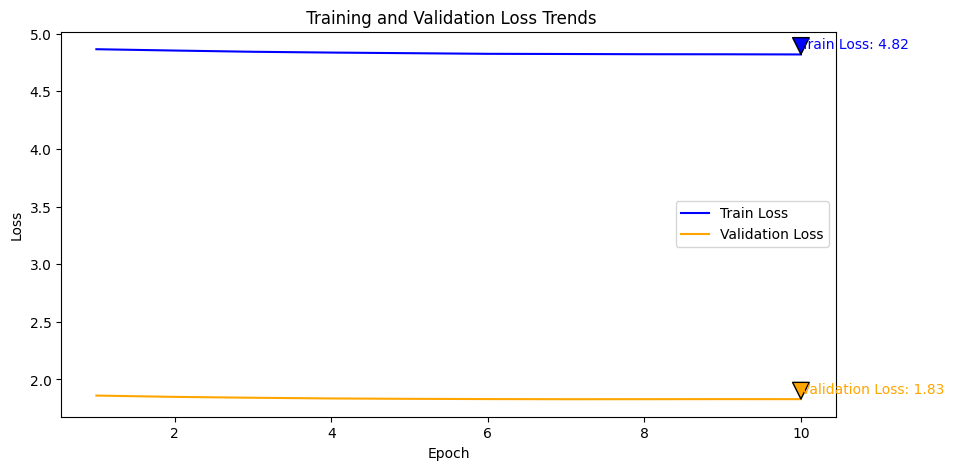

iteration 2
------------------------------------------
constructing dataset
features shape: torch.Size([152291, 14])
labels shape: torch.Size([152291, 1])
-------------------------------------------------
constructing dataset
features shape: torch.Size([145761, 14])
labels shape: torch.Size([145761, 1])
-------------------------------------------------
constructing dataset
features shape: torch.Size([109106, 14])
labels shape: torch.Size([109106, 1])
-------------------------------------------------
Features shape: torch.Size([14])
Labels shape: torch.Size([1])
sample inputs: tensor([ 0.3095, -0.3095,  0.4524, -0.1667,  0.2619, -0.5000, -0.5000, -0.2143,
        -0.0714, -0.5000,  0.0238, -0.2619,  0.0238, -0.2400]) tensor([-0.2998])
loader Features shape: torch.Size([145761, 14])
loader Labels shape: torch.Size([145761, 1])
training start
----------------------
Epoch 1/10, Traning Loss: 3.553433418273926, Validation loss: 1.8354038000106812
Epoch 2/10, Traning Loss: 3.547881841659546,

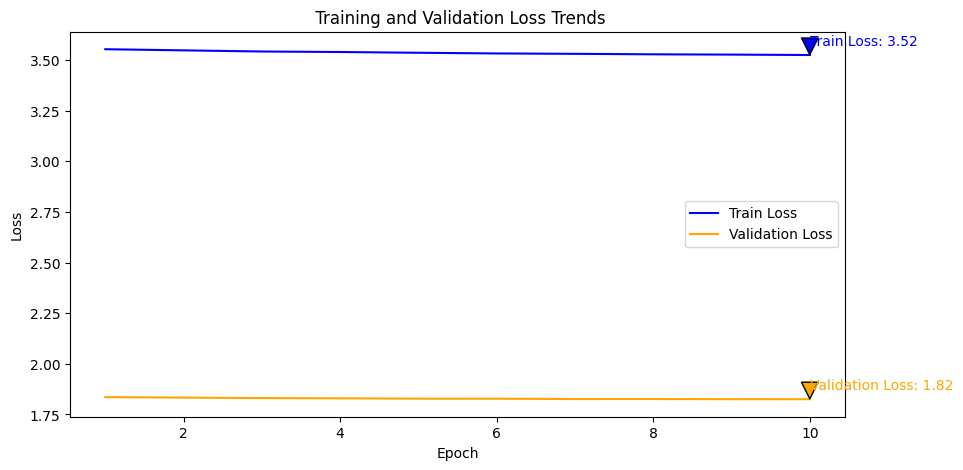

iteration 3
------------------------------------------
constructing dataset
features shape: torch.Size([229231, 14])
labels shape: torch.Size([229231, 1])
-------------------------------------------------
constructing dataset
features shape: torch.Size([74750, 14])
labels shape: torch.Size([74750, 1])
-------------------------------------------------
constructing dataset
features shape: torch.Size([103177, 14])
labels shape: torch.Size([103177, 1])
-------------------------------------------------
Features shape: torch.Size([14])
Labels shape: torch.Size([1])
sample inputs: tensor([ 0.3095, -0.3095,  0.4524, -0.1667,  0.2619, -0.5000, -0.5000, -0.2143,
        -0.0714, -0.5000,  0.0238, -0.2619,  0.0238, -0.2400]) tensor([-0.2998])
loader Features shape: torch.Size([74750, 14])
loader Labels shape: torch.Size([74750, 1])
training start
----------------------
Epoch 1/10, Traning Loss: 4.46536111831665, Validation loss: 6.838972091674805
Epoch 2/10, Traning Loss: 4.458937644958496, Valid

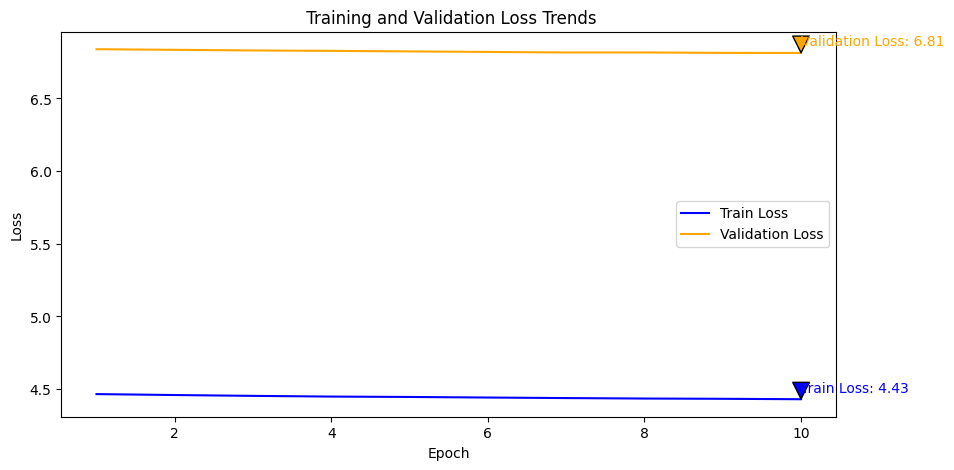

In [11]:
variables = ['ages', 'flow','exp_ratio', 'tna', 'turnover', 'Family_TNA', 'fund_no','Family_r12_2', 'Family_flow', 'Family_age', 'F_ST_Rev', 'F_r2_1','F_r12_2', 'sentiment']
model_config = {
    'input_dim': 14,
    'hidden_dims': [64],
    'dropout': 0.05,
    'lr': 0.0025,
    'num_epochs': 10
}
group_number = 1
for i in range (group_number):
    run_group_model(variables, model_config, i+1, save=False)
curr_prediction = get_mean_elementwise(all_prediction_groups)
df['prediction'] = curr_prediction.flatten()

In [12]:
#rank df based on prediction 
df_valid = df[df['mask']].copy()
#df_valid['rank'] = df_valid.groupby('Timestep')['prediction'].rank(method='first')
#df_valid['decile'] = df_valid.groupby(['Timestep'], group_keys=False)['rank'].apply(lambda x: pd.qcut(x, 10, labels=False))
df_valid = shitty_algo(df_valid)
#df_valid.to_csv('valid.csv')

In [13]:
def calculate_month_return(df):
    #df-> [label, timestep, decile, prediciton]
    #return df -> [timestep, decile, return_equal, return_pred]
    #return_equal -> equally weighted monthly return 
    #return_pred -> predicion weighted monthly return 
    results = []
    for timestep in df['Timestep'].unique():
        df_timestep = df[df['Timestep'] == timestep]
        for decile in df_timestep['decile'].unique():
            df_decile = df_timestep[df_timestep['decile'] == decile]
            return_equal = df_decile['label'].mean() #equal weight
            #predition weight 
            month_returns = torch.tensor(df_decile['label'].values, dtype=torch.float32)
            month_predictions = torch.tensor(df_decile['prediction'].values, dtype=torch.float32)
            weights = month_predictions.clone()
            if decile >= 5:
                weights -= torch.min(month_predictions)
            elif decile < 5:
                weights -= torch.max(month_predictions)
            return_pred = torch.sum(month_returns * weights) / torch.sum(weights)
            #add to output 
            results.append({
                'timestep': timestep,
                'decile': decile,
                'return_equal': return_equal/100,
                'return_pred': return_pred.item()/100
            })
    result_df = pd.DataFrame(results)
    return result_df

In [14]:
df_monthly_return = calculate_month_return(df_valid)
df_monthly_return.head()

,timestep,decile,return_equal,return_pred
0,0,-99,0.007761,0.018520
1,0,4,-0.002619,-0.005732
2,0,0,-0.025960,-0.010359
3,0,7,0.017406,0.001582
4,0,3,-0.066913,-0.095780


In [15]:
def plot_returns(df, method, cumulative=True, pred_weight = False):
    #df -> [timestep, decile, return_equal, return_pred]
    # for each decile, plot the return across all timesteps
    for i in range (10):
        df_decile = df[df['decile'] == i]
        df_decile = df_decile.sort_values('timestep')
        if cumulative and method == 'sum': 
            df_decile['cumulative_return_equal'] = df_decile['return_equal'].cumsum()
            df_decile['cumulative_return_pred'] = df_decile['return_pred'].cumsum()
        elif cumulative and method == 'logsum':
            df_decile['cumulative_return_equal'] = np.exp(np.log1p(df_decile['return_equal']).cumsum()) - 1
            df_decile['cumulative_return_pred'] = np.exp(np.log1p(df_decile['return_pred']).cumsum()) - 1
        else:
            df_decile['cumulative_return_equal'] = df_decile['return_equal']
            df_decile['cumulative_return_pred'] = df_decile['return_pred']
        if pred_weight:
            plt.plot(df_decile['timestep'], df_decile['cumulative_return_pred'],  label=f'Decile {i}')
        else:
            plt.plot(df_decile['timestep'], df_decile['cumulative_return_equal'], label=f'Decile {i}')

    plt.xlabel('Timestep')
    plt.ylabel('Cumulative Abnormal Return' if cumulative else 'Return')
    plt.title('Cumulative Abnormal Returns Over Time' if cumulative else 'Abnormal Returns Over Time')
    plt.suptitle('Prediction-weighted' if pred_weight else 'Equally-weighted', fontsize=9, y=0.87)
    plt.ylim(-1.5, 1.5)
    plt.legend()
    plt.grid(True)
    plt.show()

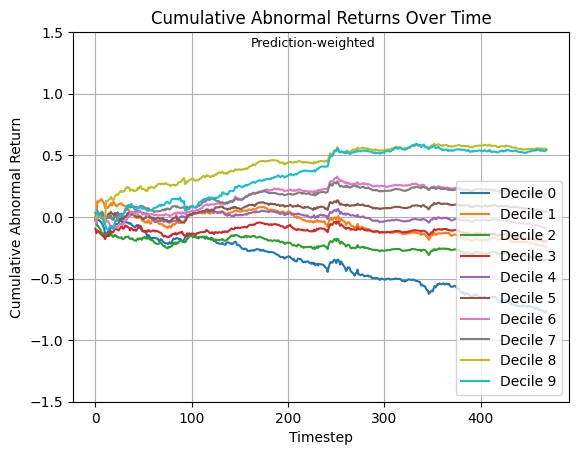

In [16]:
plot_returns(df_monthly_return, method='sum', pred_weight=True)

In [17]:
#load pretrained model 
def load_tf_weights_to_pytorch(checkpoint_path, input_size, hidden_size):
    # Use compatibility mode to access TensorFlow 1.x functionality
    tf.compat.v1.disable_eager_execution()

    # Create a NewCheckpointReader to read the TensorFlow checkpoint
    reader = tf.compat.v1.train.NewCheckpointReader(checkpoint_path)

    # Extract weights and biases from the checkpoint
    dense1_weights = reader.get_tensor('Model_Layer/NN_Layer/dense_layer_0/dense/kernel')
    dense1_bias = reader.get_tensor('Model_Layer/NN_Layer/dense_layer_0/dense/bias')
    dense2_weights = reader.get_tensor('Model_Layer/NN_Layer/last_dense_layer/dense/kernel')
    dense2_bias = reader.get_tensor('Model_Layer/NN_Layer/last_dense_layer/dense/bias')

    # Construct the PyTorch model with similar architecture
    model = NeuralNet(input_size, hidden_size, 0.05)
    
    # Load the weights and biases into the PyTorch model
    with torch.no_grad():
        model.hidden_layer1.weight = nn.Parameter(torch.tensor(dense1_weights.T))
        model.hidden_layer1.bias = nn.Parameter(torch.tensor(dense1_bias))
        model.hidden_layer_last.weight = nn.Parameter(torch.tensor(dense2_weights.T))
        model.hidden_layer_last.bias = nn.Parameter(torch.tensor(dense2_bias))

    return model

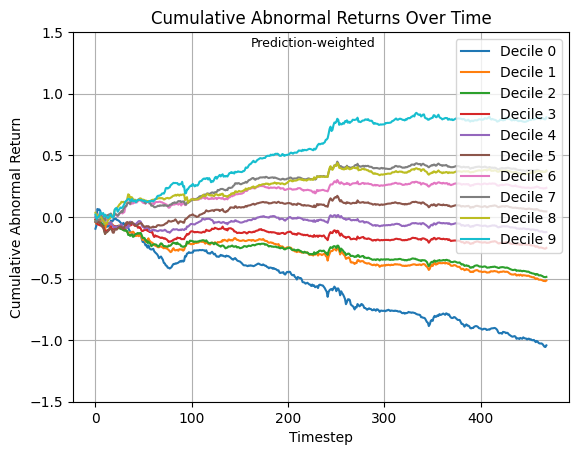

In [28]:
#load pretrained model 
new_df = convert_to_df(all_data)
new_df = sanitize_input(add_invalid_label_mask(new_df))
new_df['label'] = new_df['label'] *100
train_fold_list = []
root ='Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/output_RF/chronological_order/' 
for i in range(1, 9):
    one_train_fold = []
    for j in range(3):
        path = root + f'Train_fold_{i}/fullnew46591640.950.00.0010.01naturalTestorder{j}/model-best'
        one_train_fold.append(path)
    train_fold_list.append(one_train_fold)
sampling_folds = np.load('Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/sampling_folds/chronological_order_folds.npy', allow_pickle=True)
all_outputs = []
indexes = range (47, 61)
for checkpoint_list in train_fold_list:
    model_list = []
    input_size = 14
    hidden_size = [64]
    output_size = 1
    for checkpoint in checkpoint_list:
        pytorch_model = load_tf_weights_to_pytorch(checkpoint, input_size, hidden_size)
        model_list.append(pytorch_model)
    output_list = []
    for i in range (3):
        [train_idx_list, valid_idx_list, test_idx_list] = sampling_folds[i]
        #print(test_idx_list)
        inputs_test = get_tensor_from_df(new_df[new_df['Timestep'].isin(test_idx_list)], variables, False)
        curr_model = model_list[i]
        output_list.append(curr_model.predict(inputs_test))
    output = torch.cat(output_list, dim=0)
    all_outputs.append(output)
outputs = get_mean_elementwise(all_outputs).detach().numpy()
#uncomment to use saved prediction sets
path = '../mutualfund/Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/result_saved/chronological_order/output_all_order_465914.npz'
saveddata = np.load(path)
outputs = np.expand_dims(saveddata['Rhat_all'],axis=2)
new_df['prediction'] = outputs.flatten()
new_df_valid = new_df[new_df['mask']].copy()
#df_valid['rank'] = df_valid.groupby('Timestep')['prediction'].rank(method='first')
new_df_valid = shitty_algo(new_df_valid)
new_df_monthly_return = calculate_month_return(new_df_valid)
plot_returns(new_df_monthly_return, method='sum', pred_weight=True)